# 37_pytorch mnist - 이론 2

In [1]:
import torch
import torch.nn as nn
            # nn : neural net
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

# CNN 모델 만들기

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()     # super 함수를 통해 module을 상속받음.
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding = 'same')
                            # 1 : 입력 채널의 수 / 입력단에서는 1개임
                                # 32 : 32개의 출력을 갖도록 함
                                    # 3 : kernel 사이즈 3*3
                                        # 1 : stride 옵션
                                                # convolutional 로 인해 이미지 사이즈가 줄어들지 않도록 설정
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 'same')
                            # 32 : 32개의 입력
                                # 64 : 64개의 출력으로 나가게하기
        self.dropout = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(3136, 1000)    # 7 * 7 * 64 = 3136
            # fully connected 하는 입출력의 개수를 정해줘야 함.
                            # 3136 : 입력되는 수
                                    # 1000 : 출력할 수
        self.fc2 = nn.Linear(1000, 10)
                            # 1000 : 입력되는 수
                                    # 10 : 출력할 수

    def forward(self, x):
        
        # 1단계
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
                            # 2 * 2 크기를 갖도록 함.
            # pooling layer : 가중치가 없음.
        
        # 2단계
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # 3단계
        x = self.dropout(x)
        x = torch.flatten(x, 1)     # 차원을 바꾸는 역할만 한다.

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
                    # log_softmax : 연산 속도를 조금 더 높여 준다.

        return output

------------------------
# 이전 시간 자료 가져오기

In [3]:
# Cuda 가능하면 Cuda 모드
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cpu


In [4]:
#파라미터 설정
batch_size = 50
learning_rate = 0.0001
epoch_num = 15

In [5]:
# MNIST 데이터 불러오기
train_data = datasets.MNIST(root = './dataset/MNIST',
                            train = True,           # 훈련용 데이터로 사전 설정 가능
                            # download = True,        # 최초 1회만 다운 받아서 사용하고, 다운 받아진 후에는 False
                            transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './dataset/MNIST',
                            train = False,      # 훈련용이 아님을 설정
                            transform = transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

number of training data:  60000
number of test data:  10000


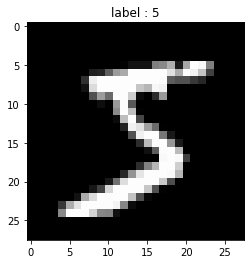

In [6]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap='gray')
                # squeeze : torchvision dataset의 한 세트는 CNN모델을 고려하여 3차원으로 설정되어있다.
                    # keras 에서는 (28, 28, 1) 로 채널이 마지막에 오지만
                    # torch 에서는 (1, 28, 28) 로 채널이 앞에 온다.
                # squeeze를 사용하면 차원을 없앤다.
plt.title('label : %s' %label)
plt.show()

In [7]:
# 미니 배치 구성 - data loader
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True)
                                                    # 읽어올 데이터셋 이름 지정
                                                                            # batch size 지정
                                                                                                # shuffle : 데이터의 순서를 학습하지 못하게 한다.
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()

-------------------
# 학습

In [8]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
                        # weight
criterion = nn.CrossEntropyLoss()

In [9]:
model.train()
        # train을 한다는 의미가 아님. 
        # 단지 train 모드 임을 설정.
i = 1
for epoch in range(epoch_num):      # 실질적인 훈련은 여기서 진행된다.
    for data, target in train_loader:
        # mini batch 를 device에 올림.
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
                # gradient 를 0으로 설정해야 다음번에 갱신한 가중치가 사용된다.
        output = model(data)
                    # data : 배치들 중의 하나씩
        loss = criterion(output, target)

        loss.backward()
            # backpropogation
        optimizer.step()
            # 가중치를 설정
        if i % 1000 == 0:
            print('Train Step : {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

Train Step : 1000	Loss: 0.278
Train Step : 2000	Loss: 0.064
Train Step : 3000	Loss: 0.041
Train Step : 4000	Loss: 0.227
Train Step : 5000	Loss: 0.020
Train Step : 6000	Loss: 0.087
Train Step : 7000	Loss: 0.010
Train Step : 8000	Loss: 0.012
Train Step : 9000	Loss: 0.008
Train Step : 10000	Loss: 0.010
Train Step : 11000	Loss: 0.034
Train Step : 12000	Loss: 0.037
Train Step : 13000	Loss: 0.003
Train Step : 14000	Loss: 0.016
Train Step : 15000	Loss: 0.001
Train Step : 16000	Loss: 0.000
Train Step : 17000	Loss: 0.020
Train Step : 18000	Loss: 0.001


# 평가

In [10]:
model.eval()
    # eval : 평가모드로 변경
    # dropout 기능은 꺼진다.

correct = 0
for data, target in test_loader :
    # data, target = Variable(data, volatile=True), Variable(target)
    data = data.to(device)
    target = target.to(device)

    output = model(data)
    prediction = output.data.max(1)[1]
                            # argmax ?
    correct += prediction.eq(target.data).sum()
                    # 예측과 맞다면 맞춘 갯수를 반환하여 저장한다.

print('Test set : Accuracy : {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set : Accuracy : 99.13%
